In [1]:
# study the jet veto efficiency in signal
# whether the signal clusters that fail jet veto are due to pileup or the other LLP

import ROOT as rt
# import root_numpy as rtnp
import csv
import re
import sys
import collections
import os

from collections import OrderedDict
import uproot
import pandas as pd

import scipy
import awkward
import numpy as np
import time
import numba
from numba import jit
from matplotlib import pyplot as plt
sys.path.append('/storage/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/lib/')
from histo_utilities import create_TH1D, create_TH2D, std_color_list, create_TGraph, make_ratio_plot

import CMS_lumi, tdrstyle
tdrstyle.setTDRStyle()
CMS_lumi.writeExtraText = 0

wH = 1
Z_MASS = 91.2


# donotdelete = []
print(sys.version)

Welcome to JupyROOT 6.22/02
3.6.8 (default, Apr  2 2020, 13:34:55) 
[GCC 4.8.5 20150623 (Red Hat 4.8.5-39)]


In [2]:
def keyToyear(key):
    for year in years:
        if year in key:
            return year

# Load ntuples

In [3]:
fpath =OrderedDict()
tree = OrderedDict()
mass = [15, 40, 55]
# mass = [15]
# VBFH = 0
# decay = 'dddd'

# mass = [7, 15, 40, 55]
# VBFH=1
# decay = 'bbbb'



VBFH = 0
decay = 'dddd' #no vbfh generated
# decay = '4Tau'
decay = 'bbbb'

mass = [15, 40, 55]

ntupler_version = 'V1p17/'

analyzer_version = 'v1/v50/'
mc_path = '/mnt/hadoop/store/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/csc/'+ntupler_version+'/MC_all/'+analyzer_version+'/normalized/'
for m in mass:
    for ct in ['100','1000','10000','100000']:
        key = 'MC_ggH_'+str(m)+'_'+str(ct)                       
#         fpath[key] = mc_path+'ggH_HToSSTobbbb_MH-125_MS-'+str(m)+'_ctau-'+str(ct)+'_137000pb_weighted.root'
        fpath[key] = mc_path+'ggH_HToSSTobbbb_MH-125_MS-'+str(m)+'_ctau-'+str(ct)+'_TuneCP5_13TeV-powheg-pythia8_1pb_weighted.root'

        fpath[key] = mc_path+'ggH_HToSSTobbbb_MH-125_MS-'+str(m)+'_ctau-'+str(ct)+'_137000pb_weighted.root'


# analyzer_version = 'v1/v48/'
# mc_path = '/mnt/hadoop/store/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/csc/'+ntupler_version+'/MC_Fall18/'+analyzer_version+'/normalized/'
# for m in mass:
#     fpath[str(m)] = mc_path+'ggH_HToSSTobbbb_MH-125_MS-'+str(m)+'.root'
NEvents = {}
NEvents_genweight = {}
for k,v in fpath.items():
    print(k)
    root_dir = uproot.open(v) 
    if not root_dir: 
        print(k, "zombie")
        continue
    tree[k] = root_dir['MuonSystem']
    NEvents[k] = root_dir['NEvents'][1]
    w = tree[k]["weight"].array()


MC_ggH_15_100
MC_ggH_15_1000
MC_ggH_15_10000
MC_ggH_15_100000
MC_ggH_40_100
MC_ggH_40_1000
MC_ggH_40_10000
MC_ggH_40_100000
MC_ggH_55_100
MC_ggH_55_1000
MC_ggH_55_10000
MC_ggH_55_100000


# nCsc with different hit vetoing

In [13]:
%%time



weight = {}

npv = {}
npu = {}
sel_ev = {}
cscRechitClusterJetVetoPt = {}
cscRechitClusterEta = {}
cscRechitCluster_index = {}
gLLP_decay_vertex_z = {}
gLLP_decay_vertex_r = {}
cluster_index = '3'
nJets = {}
gLLP_daughter_pt0 = {}
gLLP_daughter_pt1 = {}
gLLP_deltaR = {}
gLLP_pt = {}
for k, T in tree.items():
    if 'data' in k:continue
########### SELECTION: CLUSTERS ############
    
    sel_rechitcluster = np.logical_and(T.array('cscRechitCluster' + cluster_index + 'TimeTotal') < 12.5, T.array('cscRechitCluster' + cluster_index + 'TimeTotal') > -5.0)
    sel_rechitcluster = np.logical_and(sel_rechitcluster, T.array('cscRechitCluster' + cluster_index + 'TimeSpread') <= 20)
    sel_rechitcluster = np.logical_and(sel_rechitcluster, T.array('cscRechitCluster' + cluster_index + '_match_gLLP_csc'))
#     other_outside = np.logical_or(T.array('cscRechitCluster' + cluster_index + '_match_gLLP_other_decay_r')>700,\
#                                  np.abs(T.array('cscRechitCluster' + cluster_index + '_match_gLLP_other_decay_z'))>1100)
#     sel_rechitcluster = np.logical_and(sel_rechitcluster, other_outside)


    print(np.count_nonzero(sel_rechitcluster.flatten()))

########### SELECTION: JETS ############
    
    sel_jet = np.logical_and(T.array('jetPt') > 50, np.abs(T.array('jetEta')) < 2.4 )

########### SELECTION: EVENTS ############

    sel_ev[k] = T.array('METTrigger')
#     sel_ev[k] = np.logical_and(sel_ev[k] ,T.array('met') > 200)
    sel_ev[k]  = T.array('category') == 0


    sel_ev[k]  = np.logical_and(sel_ev[k], T.array('category') == 0)
    sel_ev[k] = np.logical_and(sel_ev[k] ,T.array('nLeptons') == 0)
    sel_ev[k] = np.logical_and(sel_ev[k] , sel_jet.sum()>=1)
    sel_ev[k]  = np.logical_and(sel_ev[k],sel_rechitcluster.sum() == 1)
    sel_ev[k] = np.logical_and(sel_ev[k], (T.array('nDtRings')+T.array('nCscRings'))<10)
    sel_ev[k] = np.logical_and(sel_ev[k],T.array('Flag2_all'))
    sel_ev[k] = np.logical_and(sel_ev[k], np.sum(T.array('gLLP_csc'),axis = 1) > 0)

    print(k, len(sel_ev[k]), np.count_nonzero(sel_ev[k]))
########### BRANCHES ############

 
    cscRechitClusterJetVetoPt[k] = T.array('cscRechitCluster' + cluster_index + 'JetVetoPt')[sel_rechitcluster][sel_ev[k]][:,0].flatten()
    cscRechitClusterEta[k] = T.array('cscRechitCluster' + cluster_index + 'Eta')[sel_rechitcluster][sel_ev[k]][:,0].flatten()
    cscRechitCluster_index[k] = T.array('cscRechitCluster' + cluster_index + '_match_gLLP_index')[sel_rechitcluster][sel_ev[k]][:,0].flatten()
#     gLLP_decay_vertex_r[k] = T.array('gLLP_decay_vertex_r')[sel_ev[k]]
    gLLP_decay_vertex_r[k] = T.array('gLLP_decay_vertex_r')[sel_ev[k]][list(range(np.count_nonzero(sel_ev[k]))),[1-cscRechitCluster_index[k]]][0]
    gLLP_decay_vertex_z[k] = T.array('gLLP_decay_vertex_z')[sel_ev[k]][list(range(np.count_nonzero(sel_ev[k]))),[1-cscRechitCluster_index[k]]][0]
    

    weight[k] = (T.array('weight')*T.array('pileupWeight')*T.array('higgsPtWeight'))[sel_ev[k]]
    npu[k] = T.array('npu')[sel_ev[k]]
    npv[k] = T.array('npv')[sel_ev[k]]
    sel_jet = np.logical_and(np.abs(T.array('jetEta')) <=2.0, np.abs(T.array('jetEta')) >0.8)
    nJets[k] = (sel_jet.sum())[sel_ev[k]]
    gLLP_deltaR[k] = (T.array('gLLP_deltaR'))[sel_ev[k]]
    gLLP_daughter_pt0[k] = T.array('gLLP_daughter_pt')[sel_ev[k]][list(range(np.count_nonzero(sel_ev[k]))),[(1-cscRechitCluster_index[k])*2]][0]
    gLLP_daughter_pt1[k] = T.array('gLLP_daughter_pt')[sel_ev[k]][list(range(np.count_nonzero(sel_ev[k]))),[(1-cscRechitCluster_index[k])*2+1]][0]
    gLLP_pt[k] = T.array('gLLP_pt')[sel_ev[k]][list(range(np.count_nonzero(sel_ev[k]))),[(1-cscRechitCluster_index[k])]][0]





    gLLP_deltaR[k] = (T.array('gLLP_deltaR'))[sel_ev[k]]




            

44238
MC_ggH_15_100 64975 21041
832544
MC_ggH_15_1000 1131117 206972
258647
MC_ggH_15_10000 390748 42750
29352
MC_ggH_15_100000 46219 4585
1010
MC_ggH_40_100 1324 876
460428
MC_ggH_40_1000 616372 122477
613835
MC_ggH_40_10000 898554 104340
90305
MC_ggH_40_100000 151096 13125
159
MC_ggH_55_100 207 145
179451
MC_ggH_55_1000 255722 66349
551914
MC_ggH_55_10000 1067131 103808
88939
MC_ggH_55_100000 243143 15447
CPU times: user 17 s, sys: 413 ms, total: 17.4 s
Wall time: 17.2 s


In [12]:
gLLP_pt[k][0].shape

(21041,)

# jet veto efficiency

19079 0.6113003826196342
MC_ggH_15_100 0.9402021033595328
678 0.7743362831858407
MC_ggH_40_100 0.8436159850518987
45 0.6888888888888889
MC_ggH_55_100 0.37563247581390097


Warning in <TROOT::Append>: Replacing existing TH1: hb1 (Potential memory leak).
Info in <TEfficiency::TEfficiency>: given histograms are filled with weights
Info in <TROOT::TEfficiency::SetUseWeightedEvents>: Handle weighted events for computing efficiency
Warning in <TROOT::Append>: Replacing existing TH1: hb1 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: hb1 (Potential memory leak).
Info in <TEfficiency::TEfficiency>: given histograms are filled with weights
Info in <TROOT::TEfficiency::SetUseWeightedEvents>: Handle weighted events for computing efficiency
Warning in <TROOT::Append>: Replacing existing TH1: hb1 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: hb1 (Potential memory leak).
Info in <TEfficiency::TEfficiency>: given histograms are filled with weights
Info in <TROOT::TEfficiency::SetUseWeightedEvents>: Handle weighted events for computing efficiency
Warning in <TROOT::Append>: Replacing existing TH1: hb1 (Potenti

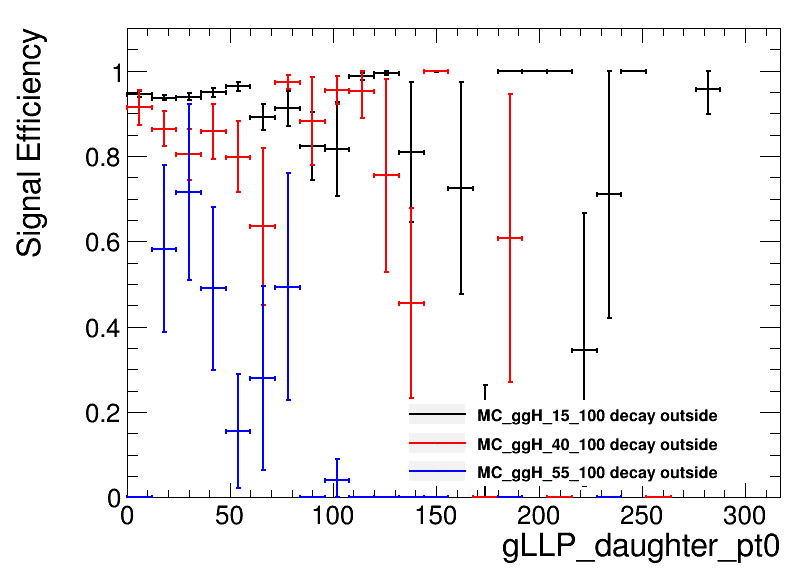

In [5]:
import numpy.ma as ma
import ROOT as rt
pEff = {}
pEff1 = {}

c = rt.TCanvas('c','c', 800, 600)
leg = rt.TLegend(0.2,0.15,0.4,0.3)
leg = rt.TLegend(0.5,0.15,0.9,0.3)


leg.SetTextSize(0.03)
leg.SetBorderSize(0)
leg.SetEntrySeparation(0.01)
var = [cscRechitClusterEta, npu, gLLP_decay_vertex_r, gLLP_decay_vertex_z, gLLP_deltaR, cscRechitClusterJetVetoPt,gLLP_daughter_pt0,gLLP_daughter_pt1]
xaxis = ['cluster #eta', 'npu', 'LLP decay radius [cm] ', 'LLP decay Z [cm]',"#Delta R between LLPs",'jet p_{T} [GeV]','gLLP_daughter_pt0','gLLP_daughter_pt1']
bins = [[25,0,3],[50,0,200],[0,10,20,40,60,80,100,200,300,700],[0,20,40,60,80,100,200,300,500,800,1200], [20,0,3],[50,0,500],[25,0,300],[50,0,500]]
j = 6
i = 0


for k in cscRechitClusterEta.keys():
    if   not(k == 'MC_ggH_40_100' or k == 'MC_ggH_15_100' or k == 'MC_ggH_55_100') :continue

#     if  k =='15':continue
    cond = cscRechitClusterJetVetoPt[k]<10
    cond_b = np.logical_or(gLLP_decay_vertex_r[k]>300, np.abs(gLLP_decay_vertex_z[k])>600)
    cond_b = np.logical_and(gLLP_decay_vertex_r[k]<50, np.abs(gLLP_decay_vertex_z[k])<100)
#     if np.count_nonzero(np.logical_and(cond_b,cond))<1:continue

    hm = create_TH1D(np.abs(var[j][k][cond]), 'hb1', axis_title = [xaxis[j],'Signal Efficiency'], binning=bins[j], weights = weight[k][cond])
    hb = create_TH1D(np.abs(var[j][k]), 'hb1', axis_title = [xaxis[j],'Signal Efficiency'], binning=bins[j], weights = weight[k])
    pEff1[k] = rt.TEfficiency(hm,hb)
    pEff1[k].SetLineWidth(2)
#     pEff1[k].SetLineStyle(2)
    pEff1[k].SetLineColor(std_color_list[i])
#     pEff1[k].Draw('' if i == 0 else 'same')
    print(np.count_nonzero(cond), np.count_nonzero(cond&cond_b)/np.count_nonzero(cond))
    
    hm = create_TH1D(np.abs(var[j][k][cond&cond_b]), 'hb1', axis_title = [xaxis[j],'Signal Efficiency'], binning=bins[j], weights = weight[k][cond&cond_b])
    hb = create_TH1D(np.abs(var[j][k][cond_b]), 'hb1', axis_title = [xaxis[j],'Signal Efficiency'], binning=bins[j], weights = weight[k][cond_b])
    pEff[k] = rt.TEfficiency(hm,hb)
    pEff[k].SetLineColor(std_color_list[i])
    pEff[k].SetLineWidth(2)
    pEff[k].Draw('' if i == 0 else 'same')
    leg.AddEntry(pEff[k],k+' decay outside')
#     leg.AddEntry(pEff1[k],k)
    i+=1
    print(k,hm.Integral()/hb.Integral())
leg.Draw()
c.Draw()

pEff['MC_ggH_15_100'].GetPaintedGraph().GetHistogram().SetMinimum(0.0)

pEff['MC_ggH_15_100'].GetPaintedGraph().GetHistogram().SetMaximum(1.1)
# pEff['MC_ggH_15_100'].GetPaintedGraph().GetHistogram().SetMinimum(0.0)
# pEff1['MC_ggH_40_1000'].GetPaintedGraph().GetHistogram().SetMaximum(2)
# pEff1['MC_ggH_40_10000'].GetPaintedGraph().GetHistogram().SetMaximum(2)
# pEff1['MC_ggH_40_100000'].GetPaintedGraph().GetHistogram().SetMaximum(2)




# pEff1[k].GetPaintedGraph().GetHistogram().SetMaximum(1)




c.Update()
# ymax = pEff[k].GetPaintedGraph().GetHistogram().GetMaximum()
# ymin = pEff[k].GetPaintedGraph().GetHistogram().GetMinimum()
# xmin = pEff[k].GetPaintedGraph().GetHistogram().GetXaxis().GetXmin()
# xmax = pEff[k].GetPaintedGraph().GetHistogram().GetXaxis().GetXmax()




#         if r:
#             c.SaveAs("../../plots/MuonSystem_Analysis/"+bdt_name+"/"+name+"_r_denomAllLLP_m"+m+".png")
#             c.SaveAs("../../plots/MuonSystem_Analysis/"+bdt_name+"/"+name+"_r_denomAllLLP_m"+m+".C")
#         else:
#             c.SaveAs("../../plots/MuonSystem_Analysis/"+bdt_name+"/"+name+"_z_denomAllLLP_m"+m+".png")
#             c.SaveAs("../../plots/MuonSystem_Analysis/"+bdt_name+"/"+name+"_z_denomAllLLP_m"+m+".C")





(21041,) (21041,)
0.8990067012024143
MC_ggH_15_100 0.9999999999999997
MC_ggH_15_100
(876,) (876,)
0.860730593607306
MC_ggH_40_100 0.9999999999999998
MC_ggH_40_100
(145,) (145,)
0.993103448275862
MC_ggH_55_100 0.9999999999999998
MC_ggH_55_100


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TROOT::Append>: Replacing existing TH1: hb1 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: hb1 (Potential memory leak).


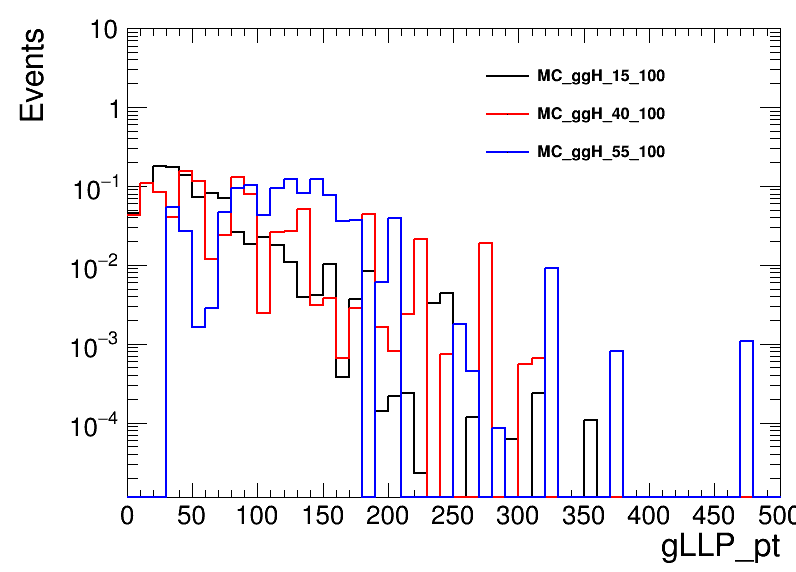

In [14]:
import numpy.ma as ma
import ROOT as rt
h = {}

c = rt.TCanvas('c','c', 800, 600)
leg = rt.TLegend(0.6,0.7,0.9,0.9)


leg.SetTextSize(0.03)
leg.SetBorderSize(0)
leg.SetEntrySeparation(0.01)
var = [cscRechitClusterEta, npu, gLLP_decay_vertex_r, gLLP_decay_vertex_z,gLLP_deltaR, cscRechitClusterJetVetoPt,gLLP_daughter_pt0,gLLP_daughter_pt1,gLLP_pt]
xaxis = ['cluster #eta', 'npu', 'LLP decay radius [cm] ', 'LLP decay Z [cm]',"#Delta R between LLPs",'jet p_{T} [GeV]','gLLP_daughter_pt0','gLLP_daughter_pt1','gLLP_pt']
bins = [[25,0,3],[50,0,200],[0,10,20,40,60,80,100,200,300,700],[0,20,40,60,80,100,200,300,500,800,1200], [20,0,5],[10,0,500],[25,0,300],[50,0,500],[50,0,500]]
j = 8
i = 0
# print(len(gLLP_decay_vertex_r[k]), cond_b[0].shape)
for k in cscRechitClusterEta.keys():
#     if not i == 1:continue
    if   not(k == 'MC_ggH_40_100' or k == 'MC_ggH_15_100' or k == 'MC_ggH_55_100') :continue
    print(gLLP_pt[k].shape,cscRechitClusterJetVetoPt[k].shape)
#     if not '15' in k:continue
#     if  k =='15':continue
    cond = cscRechitClusterJetVetoPt[k]>10
#     cond_b = np.logical_or(gLLP_decay_vertex_r[k]>0, np.abs(gLLP_decay_vertex_z[k])>0)
    cond_b = np.logical_and(gLLP_decay_vertex_r[k]<50, np.abs(gLLP_decay_vertex_z[k])<100)
#     cond_b = np.ones(gLLP_decay_vertex_r[k].shape,type=bool)
#     if np.count_nonzero(np.logical_and(cond_b,cond))<1:continue
    print(np.count_nonzero(var[j][k]>20)/len(var[j][k]))
    h[k] = create_TH1D(np.abs(var[j][k][cond& cond_b]), 'hb1', axis_title = [xaxis[j],'Events'], binning=bins[j], weights = weight[k][cond&cond_b])
#     h[k] = create_TH1D(np.abs(var[j][k]), 'hb1', axis_title = [xaxis[j],'Events'], binning=bins[j], weights = weight[k])


    h[k].SetLineColor(std_color_list[i])
    h[k].Scale(1./h[k].Integral())
    print(k,h[k].Integral())
    h[k].SetLineWidth(2)
    h[k].SetMaximum(10)
    h[k].DrawNormalized('same hist')
    leg.AddEntry(h[k],k)
    i+=1
    print(k)
leg.Draw()
c.SetLogy()
c.Draw()




c.Update()



#         if r:
#             c.SaveAs("../../plots/MuonSystem_Analysis/"+bdt_name+"/"+name+"_r_denomAllLLP_m"+m+".png")
#             c.SaveAs("../../plots/MuonSystem_Analysis/"+bdt_name+"/"+name+"_r_denomAllLLP_m"+m+".C")
#         else:
#             c.SaveAs("../../plots/MuonSystem_Analysis/"+bdt_name+"/"+name+"_z_denomAllLLP_m"+m+".png")
#             c.SaveAs("../../plots/MuonSystem_Analysis/"+bdt_name+"/"+name+"_z_denomAllLLP_m"+m+".C")






Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


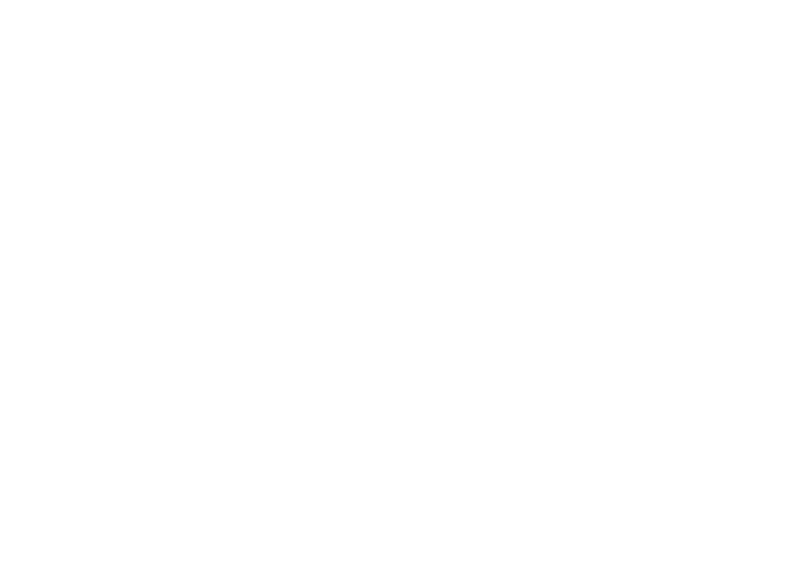

In [297]:
import importlib
importlib.reload(sys.modules['histo_utilities'])
from histo_utilities import create_TH1D, create_TH2D, std_color_list, create_TGraph, make_ratio_plot, make_ratio_pEff


pEff = {}
pEff1 = {}

c = rt.TCanvas('c','c', 800, 600)
leg = rt.TLegend(0.2,0.15,0.4,0.3)
leg.SetTextSize(0.03)
leg.SetBorderSize(0)
leg.SetEntrySeparation(0.01)
var = [cscRechitClusterEta, npu, gLLP_decay_vertex_r, gLLP_decay_vertex_z]
xaxis = ['cluster #eta', 'npu', 'LLP decay radius [cm] ', 'LLP decay Z [cm]']
bins = [[20,0,2],[50,0,200],[0,100,200,300,700,10000],[10,100,200,300,600,1500,10000]]
j = 2
i = 0
# print(len(gLLP_decay_vertex_r[k]), cond_b[0].shape)
for k in cscRechitClusterEta.keys():
    if not k =='55':continue
    print(np.max(gLLP_decay_vertex_r[k]), np.max(gLLP_decay_vertex_z[k]))
    cond = cscRechitClusterJetVetoPt[k]<10
#     hm = create_TH1D(np.abs(var[j][k][cond]), 'hb1', axis_title = [xaxis[j],'Signal Efficiency'], binning=bins[j], weights = weight[k][cond])
#     hb = create_TH1D(np.abs(var[j][k]), 'hb1', axis_title = [xaxis[j],'Signal Efficiency'], binning=bins[j], weights = weight[k])
    
    binning = bins[2]+bins[3]+[len(bins[2]),len(bins[3])]
    print(binning[-2], binning[:binning[-2]], binning[-1], binning[binning[-2]:-2])
    hm = create_TH2D(np.column_stack((np.abs(var[3][k][cond]), np.abs(var[2][k][cond]))), 'hb1', axis_title = [xaxis[3],xaxis[2],'Signal Efficiency'],\
                     binning=bins[3]+bins[2]+[len(bins[3]),len(bins[2])], weights = weight[k][cond])
    hb = create_TH2D(np.column_stack((np.abs(var[3][k]), np.abs(var[2][k]))), 'hb1', axis_title = [xaxis[3],xaxis[2],'Signal Efficiency'],\
                     binning=bins[3]+bins[2]+[len(bins[3]),len(bins[2])], weights = weight[k])
    
    pEff1[k] = rt.TEfficiency(hm,hb)
    pEff1[k].SetLineWidth(2)
    pEff1[k].SetLineColor(std_color_list[i])
    pEff1[k].Draw('colz TEXT' if i == 0 else 'same')
    
   
    leg.AddEntry(pEff1[k],k)
    i+=1
c.SetLogx()
c.SetLogy()
c.SetRightMargin(0.18)
c.Draw()

# pEff[k].GetPaintedGraph().GetHistogram().SetMaximum(2)
# pEff[k].GetPaintedGraph().GetHistogram().GetYaxis().SetRangeUser(0,2)


c.Update()
# ymax = pEff[k].GetPaintedGraph().GetHistogram().GetMaximum()
# ymin = pEff[k].GetPaintedGraph().GetHistogram().GetMinimum()
# xmin = pEff[k].GetPaintedGraph().GetHistogram().GetXaxis().GetXmin()
# xmax = pEff[k].GetPaintedGraph().GetHistogram().GetXaxis().GetXmax()




#         if r:
#             c.SaveAs("../../plots/MuonSystem_Analysis/"+bdt_name+"/"+name+"_r_denomAllLLP_m"+m+".png")
#             c.SaveAs("../../plots/MuonSystem_Analysis/"+bdt_name+"/"+name+"_r_denomAllLLP_m"+m+".C")
#         else:
#             c.SaveAs("../../plots/MuonSystem_Analysis/"+bdt_name+"/"+name+"_z_denomAllLLP_m"+m+".png")
#             c.SaveAs("../../plots/MuonSystem_Analysis/"+bdt_name+"/"+name+"_z_denomAllLLP_m"+m+".C")






3 [25, 0, 5] 3 [25, 0, 500]
[25, 0, 500, 25, 0, 5, 3, 3]
151.9856909584778
0.0011220115


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Error in <TAxis::TAxis::Set>: bins must be in increasing order
Error in <TAxis::TAxis::Set>: bins must be in increasing order
Warning in <TROOT::Append>: Replacing existing TH1: hb1 (Potential memory leak).


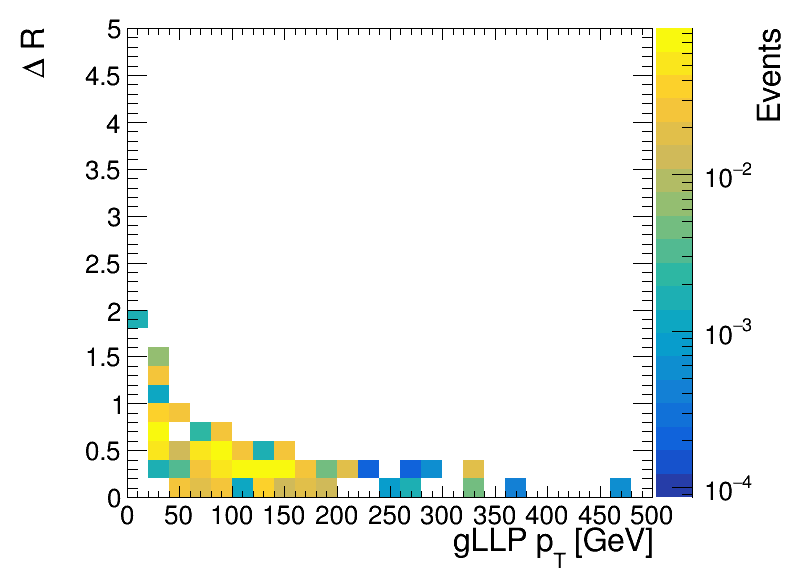

In [47]:
import importlib
importlib.reload(sys.modules['histo_utilities'])
from histo_utilities import create_TH1D, create_TH2D, std_color_list, create_TGraph, make_ratio_plot, make_ratio_pEff


pEff = {}
pEff1 = {}
hb = {}
c = rt.TCanvas('c','c', 800, 600)
leg = rt.TLegend(0.2,0.15,0.4,0.3)
leg.SetTextSize(0.03)
leg.SetBorderSize(0)
leg.SetEntrySeparation(0.01)
var = [cscRechitClusterEta, npu, gLLP_decay_vertex_r, gLLP_decay_vertex_z,gLLP_pt,gLLP_deltaR]
xaxis = ['cluster #eta', 'npu', 'LLP decay radius [cm] ', 'LLP decay Z [cm]','gLLP p_{T} [GeV]','#Delta R']
bins = [[20,0,2],[50,0,200],[0,100,200,300,700,10000],[10,100,200,300,600,1500,10000],[25,0,500],[25,0,5]]
j = (5,4)
i = 0
# print(len(gLLP_decay_vertex_r[k]), cond_b[0].shape)
for k in cscRechitClusterEta.keys():
    if   not(k == 'MC_ggH_40_100' or k == 'MC_ggH_15_100' or k == 'MC_ggH_55_100') :continue
    if   not k == 'MC_ggH_55_100' :continue


    cond = cscRechitClusterJetVetoPt[k]<10
    
    binning = bins[j[0]]+bins[j[1]]+[len(bins[j[0]]),len(bins[j[1]])]
    print(binning[-2], binning[:binning[-2]], binning[-1], binning[binning[-2]:-2])
    print(bins[j[1]]+bins[j[0]]+[len(bins[j[1]]),len(bins[j[0]])])
    hb[k] = create_TH2D(np.column_stack((np.abs(var[j[1]][k]), np.abs(var[j[0]][k]))), 'hb1', axis_title = [xaxis[j[1]],xaxis[j[0]],'Events'],\
                     binning=bins[j[1]]+bins[j[0]]+[len(bins[j[1]]),len(bins[j[0]])], weights = weight[k]*137000)
    hb[k] = create_TH2D(np.column_stack((np.abs(var[j[1]][k]), np.abs(var[j[0]][k]))), 'hb1', axis_title = [xaxis[j[1]],xaxis[j[0]],'Events'],\
                     binning=bins[j[1]]+bins[j[0]], weights = weight[k]*137000)
    hb[k].SetLineWidth(2)
    hb[k].SetLineColor(std_color_list[i])
    hb[k].DrawNormalized('colz')
    print(hb[k].Integral())
    print(np.sum(weight[k]))
   
    i+=1
c.SetLogz()
c.SetRightMargin(0.18)

# pEff[k].GetPaintedGraph().GetHistogram().SetMaximum(2)
# pEff[k].GetPaintedGraph().GetHistogram().GetYaxis().SetRangeUser(0,2)
c.Draw()

# ymax = pEff[k].GetPaintedGraph().GetHistogram().GetMaximum()
# ymin = pEff[k].GetPaintedGraph().GetHistogram().GetMinimum()
# xmin = pEff[k].GetPaintedGraph().GetHistogram().GetXaxis().GetXmin()
# xmax = pEff[k].GetPaintedGraph().GetHistogram().GetXaxis().GetXmax()




#         if r:
#             c.SaveAs("../../plots/MuonSystem_Analysis/"+bdt_name+"/"+name+"_r_denomAllLLP_m"+m+".png")
#             c.SaveAs("../../plots/MuonSystem_Analysis/"+bdt_name+"/"+name+"_r_denomAllLLP_m"+m+".C")
#         else:
#             c.SaveAs("../../plots/MuonSystem_Analysis/"+bdt_name+"/"+name+"_z_denomAllLLP_m"+m+".png")
#             c.SaveAs("../../plots/MuonSystem_Analysis/"+bdt_name+"/"+name+"_z_denomAllLLP_m"+m+".C")





